# CFL Code Demo 

This example runs a basic CFL experiment on Visual Bars Data 


In [1]:
import numpy as np

## Loading Data 

### Key Points for Loading Data
1. The data should consist of a data set `X` and a data set `Y` that are aligned (each row in `X` corresponds to the row with the same index in `Y`)
2. 'X' should be the causal data set and 'Y' should be the effect data 
3. For most instances of CFL, `X` and `Y` should be reshaped such that that each one is a 2D array with dimensions (n_samples, n_features). Some instances of CFL require that `X` be a 4-D array.

### Load the Visual Bars Data
To create a visual bars data set, we need to import the file `generate_visual_bars_data.py`. If you are trying to generate the visual bars data from outside of the root directory of the `cfl` reposity, add the `visual_bars` directory path to the PYTHONPATH (same as you did for the `cfl` package) for easy importing. 

See the [visual bars page](https://cfl.readthedocs.io/en/latest/Visual_Bars_data.html) for background on the visual bars data set.

In [2]:
#import the file to generate visual bars data 
import visual_bars.generate_visual_bars_data as vbd

# uncomment this line and use it instead if you have added `visual_bars` to the pythonpath
# import generate_visual_bars_data as vbd

In [3]:
# In order to generate visual bars data, we set the number of images we want to generate (`n_samples`), the size of each image in pixels (`im_shape`), and the intensity of random noise in the image (`noise_lvl`). To have reproducible results, we also will set a random seed. 

# create visual bars data 
n_samples = 5000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)


In [4]:
# We save an array of images to a variable `X` and the array of target behavior to a variable `Y`. Note that `X` and `Y` are aligned - they must have the same number of observations, and the nth image in `X` must correspond to the nth target value in `Y`. 

# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()

# X and Y have the same number of rows  
print(X.shape)
print(Y.shape)
print(X.shape[0]==Y.shape[0])



(5000, 10, 10)
(5000,)
True


## Shaping the Data 

Before putting our data into CFL, we must reshape `X` and `Y` into the right shapes to be passed through the first step, the conditional density estimator (CDE), of CFL. For further guidelines about shaping your data, see [info about CDEs](https://cfl.readthedocs.io/en/latest/CDEs.html#input-shape-for-cdes). 


For this CDE, we must reshape `X` to be a 4-D array with dimensions (n_samples, im_height, im_width, n_channels) and `Y` to be 2 dimensional, with shape (n_samples, n_features)

In [5]:
#reformat x, y into the right shape for the neural net 

# expand X 
X = np.expand_dims(X, -1) 
print(X.shape) #black and white images have just one channel

# expand Y
Y = np.expand_dims(Y, -1)
print(Y.shape)

(5000, 10, 10, 1)
(5000, 1)


## Setting up the CFL Pipeline 

We will now set up an `Experiment`. The `Experiment` will create a CFL pipeline and automatically save all the parameters, results, and the trained models generated during this experiment.


CFL takes in several sets of parameters, each in dictionary form: 
- `data_info`  
- `CDE_params`   
- `cause_clusterer_params`   
- `effect_clusterer_params`   

For further details on the meaning of these parameters, consult the documentation for the clusterer and the CondExp base class. 

Note that not all of the parameters need to be specified - if they are not specified, default values will be provided.  

In this case, we use a convolutional neural net for the CDE, and K-means for clustering. Consult the documentation for the other available models. Note that we didn't specify some parameters, and so those parameters are given default values (values printed below). While we use the default CondExpCNN parameters for simplicity here, note below that these parameters could benefit from tuning to improve training. Please consult the ["CDE Hyperparameter Tuning with Optuna"](https://cfl.readthedocs.io/en/latest/examples/train_cde_with_optuna_pruner.html) demo for more information on neural network tuning.

In [6]:
from cfl.experiment import Experiment
from sklearn.cluster import KMeans

# the parameters should be passed in dictionary form 
data_info = {'X_dims' : X.shape, 
             'Y_dims' : Y.shape, 
             'Y_type' : 'categorical' #options: 'categorical' or 'continuous'
            }
cnn_params = {'model' : 'CondExpCNN'} # pass in empty parameter dictionaries to use the default parameter values (not allowed for data_info)
cause_clusterer_params =  {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}
effect_clusterer_params = {'model' : 'KMeans', 'n_clusters' : 2, 'verbose' : 0}

# steps of this CFL pipeline
block_names = ['CondDensityEstimator', 'CauseClusterer', 'EffectClusterer']
block_params = [cnn_params, cause_clusterer_params, effect_clusterer_params]

# folder to save results to 
save_path = 'results' 

# create the experiment!
my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, results_path=save_path)

All results from this run will be saved to results/experiment0002
filters not specified in input, defaulting to [32, 16]
input_shape not specified in input, defaulting to (10, 10, 1)
kernel_size not specified in input, defaulting to [(3, 3), (3, 3)]
pool_size not specified in input, defaulting to [(2, 2), (2, 2)]
padding not specified in input, defaulting to ['same', 'same']
conv_activation not specified in input, defaulting to ['relu', 'relu']
dense_units not specified in input, defaulting to 16
dense_activation not specified in input, defaulting to relu
output_activation not specified in input, defaulting to None
batch_size not specified in input, defaulting to 32
n_epochs not specified in input, defaulting to 20
optimizer not specified in input, defaulting to adam
opt_config not specified in input, defaulting to {}
verbose not specified in input, defaulting to 1
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show

## Training and Predicting with a CFL object  

We now train the CFL object on our data.

#################### Beginning CFL Experiment training. ####################
Beginning CondDensityEstimator training...
No GPU device detected.
Train on 3750 samples, validate on 1250 samples
Epoch 1/20
3750/3750 [==============================] - 7s 2ms/sample - loss: 0.1972 - val_loss: 0.1582
Epoch 2/20
3750/3750 [==============================] - 1s 373us/sample - loss: 0.1479 - val_loss: 0.1469
Epoch 3/20
3750/3750 [==============================] - 2s 405us/sample - loss: 0.1407 - val_loss: 0.1450
Epoch 4/20
3750/3750 [==============================] - 1s 385us/sample - loss: 0.1385 - val_loss: 0.1471
Epoch 5/20
3750/3750 [==============================] - 1s 366us/sample - loss: 0.1375 - val_loss: 0.1481
Epoch 6/20
3750/3750 [==============================] - 1s 310us/sample - loss: 0.1361 - val_loss: 0.1448
Epoch 7/20
3750/3750 [==============================] - 1s 356us/sample - loss: 0.1349 - val_loss: 0.1446
Epoch 8/20
3750/3750 [==============================] - 1s 358us/sam

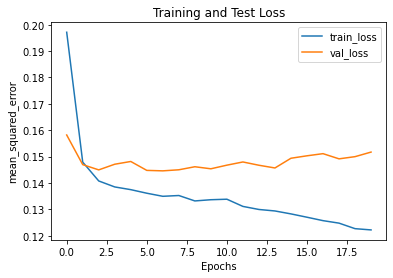

Loading parameters from  tmp_checkpoints01122021154707/best_weights
Saving parameters to  results/experiment0002/trained_blocks/CondDensityEstimator
CondDensityEstimator training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Beginning EffectClusterer training...
EffectClusterer training complete.
Experiment training complete.


In [7]:
train_results = my_exp.train()

In [9]:
# The results are returned as a dictionary of dictionaries 
# 
# The `x_labels` and `y_labels` are the macrovariable labels for each sample in the `X` and `Y` data set, respectively, 
# Below, we print the first few `x_lbls`. We can see that, there are 4 classes in the data, and that they are represented by the numbers `0` through `3`. Each of these labels tells us the macrovariable to which the corresponding visual bars image was assigned. 

print('First 20 cause macrostate assignments')
print(train_results['CauseClusterer']['x_lbls'][:20])
print('First 20 effect macrostate assignments')
print(train_results['EffectClusterer']['y_lbls'][:20])

First 20 cause macrostate assignments
[0 3 1 2 3 3 0 2 1 3 1 1 3 0 3 1 2 1 2 3]
First 20 effect macrostate assignments
[1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0]


## Predicting on a New Dataset

In [ ]:
# To predict on different data using the same, already trained CFL pipeline, we just create a second data set, and call the predict method on that new dataset: 


In [10]:
n_samples = 100
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180 

# make second dataset for prediction
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X_new = vb_data.getImages()
Y_new = vb_data.getTarget()

#reformat x, y into the right shape for the neural net 
X_new_CNN = np.expand_dims(X_new, -1) 
Y_new_CNN = np.expand_dims(Y_new, -1)

# put X, Y into a new Dataset object
# add a new dataset to this experiment's known set of data sets 

# register the new dataset with the Experiment
my_exp.add_dataset(X=X_new_CNN, Y=Y_new_CNN, dataset_name='predict_data')  

# predict! 
results_new = my_exp.predict('predict_data')

Beginning Experiment prediction.
Beginning CondDensityEstimator prediction...
CondDensityEstimator prediction complete.
Beginning CauseClusterer prediction...
CauseClusterer prediction complete.
Beginning EffectClusterer prediction...
EffectClusterer prediction complete.
Prediction complete.


In [11]:
# take a look at some of the results for the new data set 
print(results_new['CauseClusterer']['x_lbls'][:20])

[0 1 1 0 0 3 1 2 0 2 0 3 0 0 1 0 2 1 2 1]


## Visualize Results 

We can view some images with their predicted label using the `viewImagesandLabels` function. 

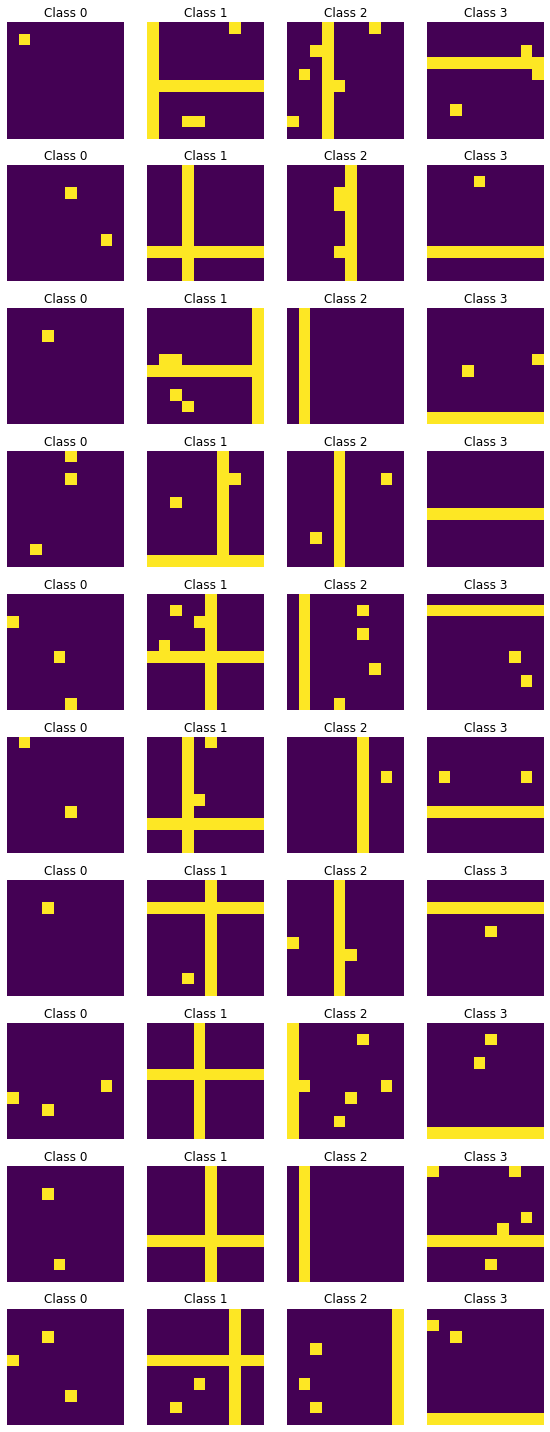

In [13]:
import visual_bars.visual_bars_vis as vis

vis.viewImagesAndLabels(X_new, im_shape=im_shape, n_examples=10, x_lbls=results_new['CauseClusterer']['x_lbls'])

As we can see, CFL has done a pretty good job of recovering the observational partitions (with some errors). For the most part, the images with a horizontal bar, a vertical bar, both, or neither, have been separated into distinct classes. Try this experiment again with a different CDE or a different sample size, and see how your results differ! 